# 12-04 개체명 인식의 BIO 표현 이해하기

이번에는 기존에 공개된 개체명 인식기를 사용하는 것이 아니라, 직접 목적에 맞는 데이터를 준비하여 모델을 만들어보겠습니다. 양방향 LSTM을 이용해서 개체명 인식기를 만들어봅니다.

## BIO 표현

개체명 인식에서 코퍼스로부터 개체명을 인식하기 위한 방법으로는 여러 방법이 있지만, 여기서는 가장 보편적인 방법 중 하나인 BIO 태깅 방법을 소개합니다.  

B: Begin의 약자로 개체명이 시작되는 부분  
I: Inside의 약자로 개체명의 내부 부분  
O: Outside의 약자로 개체명이 아닌 부분

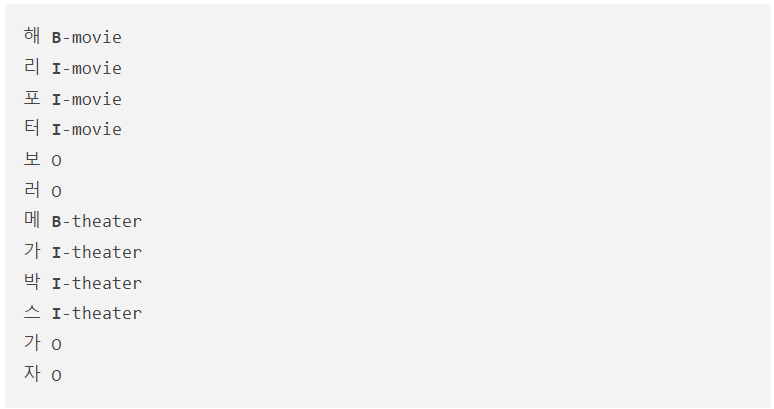  
영화 제목에 대한 개체명과 극장에 대한 개체명 인식

## 개체명 인식 데이터 이해하기

CONLL2003은 개체명 인식을 위한 전통적인 영어 데이터셋입니다. 해당 데이터는 BIO 표현 방법을 사용합니다.  

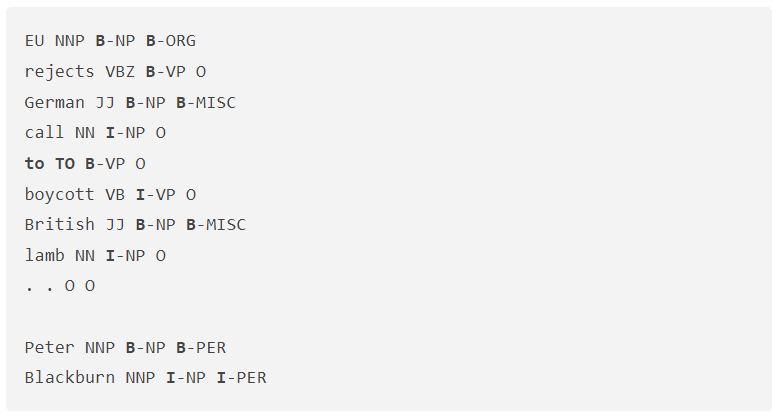  
데이터의 형식은 [단어] [품사 태깅] [청크 태깅] [개체명 태깅]의 형식

## 데이터 전처리하기

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")

f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [2]:
print("전체 샘플 개수: ", len(tagged_sentences))

전체 샘플 개수:  14041


In [3]:
print('첫번째 샘플 :',tagged_sentences[0])

첫번째 샘플 : [['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [4]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 14,041개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [5]:
print('첫번째 샘플의 문장 :',sentences[0])
print('첫번째 샘플의 레이블 :',ner_tags[0])

첫번째 샘플의 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
첫번째 샘플의 레이블 : ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


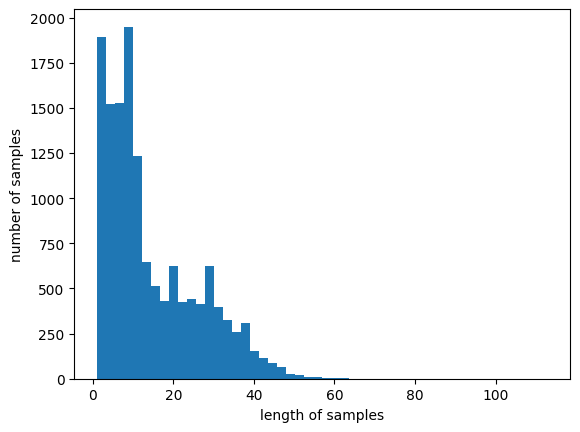

In [6]:
print('샘플의 최대 길이 : %d' % max(len(sentence) for sentence in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [7]:
# 정수 인코딩 진행(높은 빈도수를 가진 상위 약 4,000개의 단어만을 사용)
vocab_size = 4000
src_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [8]:
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


In [9]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [10]:
print('첫번째 샘플의 문장 :',X_train[0])
print('첫번째 샘플의 레이블 :',y_train[0])

첫번째 샘플의 문장 : [989, 1, 205, 629, 7, 3939, 216, 1, 3]
첫번째 샘플의 레이블 : [4, 1, 7, 1, 1, 1, 7, 1, 1]


In [11]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [12]:
# 첫 번째 문장 디코딩
decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 각 정수로 변환된 단어에 대해서
    decoded.append(index_to_word[index]) # 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))
# 일부 단어가 OOV로 대체되었음 확인

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [13]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [15]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [16]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


## 양방향 LSTM(Bi-directional LSTM)으로 개체명 인식기 만들기

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

# 모든 시점에 대해서 개체명 레이블 개수만큼의 선택지 중 하나를 예측하는 다중 클래스 분류 문제를 수행하는 모델
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True)) # 패딩을 하느라 숫자 0이 많아질 경우에 mask_zero=True를 설정하여 숫자 0은 연산에서 제외시킨다는 옵션
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax'))) # LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용할 필요가 있을 때 사용
# 다중 클래스 분류 문제의 경우, 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=8, validation_data=(X_test, y_test))


Epoch 1/8
88/88 [==============================] - 82s 834ms/step - loss: 0.9598 - accuracy: 0.8243 - val_loss: 0.6509 - val_accuracy: 0.8332
Epoch 2/8
88/88 [==============================] - 77s 872ms/step - loss: 0.5112 - accuracy: 0.8476 - val_loss: 0.4169 - val_accuracy: 0.8718
Epoch 3/8
88/88 [==============================] - 91s 1s/step - loss: 0.3573 - accuracy: 0.8924 - val_loss: 0.2950 - val_accuracy: 0.9134
Epoch 4/8
88/88 [==============================] - 84s 954ms/step - loss: 0.2494 - accuracy: 0.9275 - val_loss: 0.2185 - val_accuracy: 0.9397
Epoch 5/8
88/88 [==============================] - 99s 1s/step - loss: 0.1838 - accuracy: 0.9463 - val_loss: 0.1827 - val_accuracy: 0.9489
Epoch 6/8
88/88 [==============================] - 91s 1s/step - loss: 0.1480 - accuracy: 0.9565 - val_loss: 0.1738 - val_accuracy: 0.9519
Epoch 7/8
88/88 [==============================] - 65s 735ms/step - loss: 0.1258 - accuracy: 0.9629 - val_loss: 0.1605 - val_accuracy: 0.9550
Epoch 8/8
88/88

In [18]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 7s 77ms/step - loss: 0.1577 - accuracy: 0.9554

 테스트 정확도: 0.9554


In [19]:
i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict(np.array([X_test[i]]))

# 확률 벡터를 정수 레이블로 변경.
y_predicted = np.argmax(y_predicted, axis=-1)

# 원-핫 벡터를 정수 인코딩으로 변경.
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag].upper(), index_to_ner[pred].upper()))

# 사실 이번에 사용한 정확도 측정 방법이 그다지 적절하지는 않았는데, 대부분의 단어가 개체명이 아니라는 'O'가 태깅된 상황에서 정확도가 수많은 'O'로 인해 결정되고 있기 때문입니다. 이를 해결하기 위해서 다음 실습에서 F1-score를 도입해보겠습니다.

1/1 [==============================] - 5s 5s/step
단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to         